<a href="https://colab.research.google.com/github/cjm19954/Machine-Learning-Course/blob/master/B_S_ANN_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
from sympy import init_printing

In [ ]:
# DGM neural network model

class DGMNet(tf.keras.Model):
    
    def __init__(self, n_layers, n_nodes, dimensions=1):
        """
        Parameters:
            - n_layers:     number of layers
            - n_nodes:      number of nodes in (inner) layers
            - dimensions:   number of spacial dimensions
        """
        super().__init__()
        
        self.n_layers = n_layers

        self.initial_layer = DenseLayer(dimensions + 1, n_nodes, activation="relu")
        self.lstmlikelist = []
        for _ in range(self.n_layers):
            self.lstmlikelist.append(LSTMLikeLayer(dimensions + 1, n_nodes, activation="relu"))
        self.final_layer = DenseLayer(n_nodes, 1, activation=None)


    def call(self, t, x):
        X = tf.concat([t,x], 1)

        S = self.initial_layer.call(X)
        for i in range(self.n_layers):
            S = self.lstmlikelist[i].call({'S': S, 'X': X})
        result = self.final_layer.call(S)

        return result
    


# Neural network layers

class DenseLayer(tf.keras.layers.Layer):
        

  def __init__(self, n_inputs, n_outputs, activation):
      """
      Parameters:
      - n_inputs:     number of inputs
      - n_outputs:    number of outputs
      - activation:   activation function
      """
      super(DenseLayer, self).__init__()
      self.n_inputs = n_inputs
      self.n_outputs = n_outputs
      self.W = self.add_weight(shape=(self.n_inputs, self.n_outputs),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(1, self.n_outputs),
                               initializer='random_normal',
                               trainable=True)
      self.activation = _get_function(activation)
      
  def call(self, inputs):
        S = tf.add(tf.matmul(inputs, self.W), self.b)
        S = self.activation(S)

        return S



class LSTMLikeLayer(tf.keras.layers.Layer):
    def __init__(self, n_inputs, n_outputs, activation):
        """
        Parameters:
            - n_inputs:     number of inputs
            - n_outputs:    number of outputs
            - activation:   activation function
        """
      
        super(LSTMLikeLayer, self).__init__()

        self.n_outputs = n_outputs
        self.n_inputs = n_inputs

        '''
        self.Uz = self.add_weight("Uz",shape=(self.n_inputs, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.Ug = self.add_weight("Ug",shape=(self.n_inputs, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.Ur = self.add_weight("Ur",shape=(self.n_inputs, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.Uh = self.add_weight("Uh",shape=(self.n_inputs, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.Wz = self.add_weight("Wz",shape=(self.n_inputs, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.Wg = self.add_weight("Wg",shape=(self.n_inputs, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.Wr = self.add_weight("Wr",shape=(self.n_inputs, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.Wh = self.add_weight("Uh",shape=(self.n_inputs, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.bz = self.add_weight("bz",shape=(1, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.bg = self.add_weight("bg",shape=(1, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.br = self.add_weight("br",shape=(1, self.n_outputs), initializer = 'random_normal', trainable = True)
        self.bh = self.add_weight("bh",shape=(1, self.n_outputs), initializer = 'random_normal', trainable = True)
        '''
        
        
        self.Uz = self.add_weight("Uz", shape=[self.n_inputs, self.n_outputs])
        self.Ug = self.add_weight("Ug", shape=[self.n_inputs, self.n_outputs])
        self.Ur = self.add_weight("Ur", shape=[self.n_inputs, self.n_outputs])
        self.Uh = self.add_weight("Uh", shape=[self.n_inputs, self.n_outputs])
        self.Wz = self.add_weight("Wz", shape=[self.n_outputs, self.n_outputs])
        self.Wg = self.add_weight("Wg", shape=[self.n_outputs, self.n_outputs])
        self.Wr = self.add_weight("Wr", shape=[self.n_outputs, self.n_outputs])
        self.Wh = self.add_weight("Wh", shape=[self.n_outputs, self.n_outputs])
        self.bz = self.add_weight("bz", shape=[1, self.n_outputs])
        self.bg = self.add_weight("bg", shape=[1, self.n_outputs])
        self.br = self.add_weight("br", shape=[1, self.n_outputs])
        self.bh = self.add_weight("bh", shape=[1, self.n_outputs])
        

        self.activation = _get_function(activation)


    
    def call(self, inputs):
        S = inputs['S']
        X = inputs['X']

        Z = self.activation(tf.add(tf.add(tf.matmul(X, self.Uz), tf.matmul(S, self.Wz)), self.bz))
        G = self.activation(tf.add(tf.add(tf.matmul(X, self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.activation(tf.add(tf.add(tf.matmul(X, self.Ur), tf.matmul(S, self.Wr)), self.br))
        H = self.activation(tf.add(tf.add(tf.matmul(X, self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        Snew = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z, S))

        return Snew



def _get_function(name):
    f = None
    if name == "tanh":
        f = tf.nn.tanh
    elif name == "sigmoid":
        f = tf.nn.sigmoid
    elif name == "relu":
        f = tf.nn.relu
    elif not name:
        f = tf.identity
    
    assert f is not None
    
    return f

Functions

In [ ]:
# Sampling
def sampler(N1, N2, N3):
    np.random.seed(42)
    # Sampler #1: PDE domain
    t1 = np.random.uniform(low=T0,
                           high=T,
                           size=[N1,1])
    s1 = np.random.uniform(low=S1,
                           high=S2,
                           size=[N1,1])

    # Sampler #2: boundary condition
    t2 = np.zeros(shape=(1, 1))
    s2 = np.zeros(shape=(1, 1))
    
    # Sampler #3: initial/terminal condition
    t3 = T * np.ones((N3,1)) #Terminal condition
    s3 = np.random.uniform(low=S1,
                           high=S2,
                           size=[N3,1])
    
    return (t1, s1, t2, s2, t3, s3)

    # Loss function
def loss(model, t1, x1, t2, x2, t3, x3):
    # Loss term #1: PDE
    V = model(t1, x1)
    V_t = tf.gradients(V, t1)[0]
    V_x = tf.gradients(V, x1)[0]
    V_xx = tf.gradients(V_x, x1)[0]
    f = V_t + r*x1*V_x + 0.5*sigma**2*x1**2*V_xx - r*V 

    L1 = tf.reduce_mean(tf.square(f))

    # Loss term #2: boundary condition
    #L2 = tf.reduce_mean(tf.square(V)) 
    
    # Loss term #3: initial/terminal condition
    L3 = tf.reduce_mean(tf.square(model(t3, x3) - tf.math.maximum(x3-K,0)))

    return (L1, L3)

    # B-S's analytical known solution
def analytical_solution(t, x):
    #C = SN(d1) - Xe- rt N(d2)
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(x / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(x / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (x * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def _mean_error(actual:np.ndarray, predicted: np.ndarray, lower_bound, upper_bound):
    """Mean simple error"""
    return (np.mean(np.abs(_error(actual, predicted))))/(upper_bound - lower_bound)
    



def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    EPSILON = 1e-10
    return _error(actual, predicted) / (actual + EPSILON)

def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))

def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


Program

In [ ]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Strike price

K = 0.5

# PDE parameters
r = 0.05            # Interest rate
sigma = 0.25        # Volatility

# Time limits
T0 = 0.0 + 1e-10    # Initial time
T  = 1.0            # Terminal time

# Space limits
S1 = 0.0 + 1e-10    # Low boundary
S2 = 1.0            # High boundary

Building the network

In [ ]:
# Neural Network definition
num_layers = 3
nodes_per_layer = 6
ann = DGMNet(num_layers, nodes_per_layer)

Training

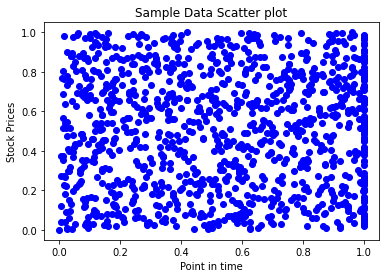

In [ ]:
# Number of samples
NS_1 = 1000
NS_2 = 0
NS_3 = 100


t1, s1, t2, s2, t3, s3 = sampler(NS_1, NS_2, NS_3)
t_total = np.concatenate((t1,t2,t3))
s_total = np.concatenate((s1,s2,s3))

plt.scatter(t_total,s_total, c="blue")
plt.title('Sample Data Scatter plot')
plt.xlabel('Point in time')
plt.ylabel('Stock Prices')
plt.show()

In [ ]:
tf.compat.v1.disable_eager_execution()
t1_t = tf.compat.v1.placeholder(tf.float32, [None,1])
x1_t = tf.compat.v1.placeholder(tf.float32, [None,1])
t2_t = tf.compat.v1.placeholder(tf.float32, [None,1])
x2_t = tf.compat.v1.placeholder(tf.float32, [None,1])
t3_t = tf.compat.v1.placeholder(tf.float32, [None,1])
x3_t = tf.compat.v1.placeholder(tf.float32, [None,1])

#L1_t, L2_t, L3_t = loss(ann, t1_t, x1_t, t2_t, x2_t, t3_t, x3_t)
#loss_t = L1_t + L2_t + L3_t



In [ ]:
volatility_list = 0.18
stages_list = [5, 10, 30]
layers_list = [3, 5, 7]
npl_list = [3, 6, 9, 12, 15]

Stage: 0000, Loss: 1.031273e-01, L1: 4.206353e-02, L3: 6.106379e-02, 4.920429 seconds
Stage: 0001, Loss: 8.131485e-02, L1: 2.498431e-02, L3: 5.633054e-02, 0.120687 seconds
Stage: 0002, Loss: 6.817447e-02, L1: 1.513263e-02, L3: 5.304184e-02, 0.111984 seconds
Stage: 0003, Loss: 5.993669e-02, L1: 9.242578e-03, L3: 5.069411e-02, 0.104187 seconds
Stage: 0004, Loss: 5.465005e-02, L1: 5.822563e-03, L3: 4.882748e-02, 0.107718 seconds
Stage: 0005, Loss: 5.099268e-02, L1: 3.736753e-03, L3: 4.725593e-02, 0.126644 seconds
Stage: 0006, Loss: 4.835025e-02, L1: 2.490472e-03, L3: 4.585978e-02, 0.104680 seconds
Stage: 0007, Loss: 4.627334e-02, L1: 1.718615e-03, L3: 4.455473e-02, 0.101968 seconds
Stage: 0008, Loss: 4.455504e-02, L1: 1.238264e-03, L3: 4.331678e-02, 0.101350 seconds
Stage: 0009, Loss: 4.306570e-02, L1: 9.248036e-04, L3: 4.214089e-02, 0.098163 seconds
Stage: 0010, Loss: 4.176703e-02, L1: 7.427529e-04, L3: 4.102428e-02, 0.105815 seconds
Stage: 0011, Loss: 4.059590e-02, L1: 6.308411e-04, L3:

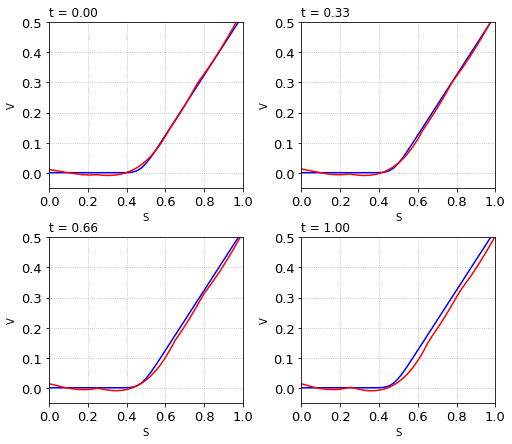

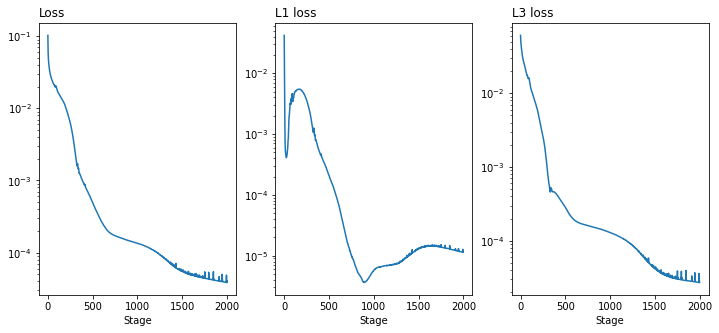

Stage: 0000, Loss: 2.956615e-02, L1: 6.612893e-04, L3: 2.890486e-02, 5.014511 seconds
Stage: 0001, Loss: 2.734023e-02, L1: 7.640143e-04, L3: 2.657622e-02, 0.113762 seconds
Stage: 0002, Loss: 2.541567e-02, L1: 9.455691e-04, L3: 2.447010e-02, 0.117463 seconds
Stage: 0003, Loss: 2.371969e-02, L1: 1.149884e-03, L3: 2.256981e-02, 0.116031 seconds
Stage: 0004, Loss: 2.220241e-02, L1: 1.363858e-03, L3: 2.083855e-02, 0.111999 seconds
Stage: 0005, Loss: 2.085948e-02, L1: 1.630148e-03, L3: 1.922933e-02, 0.112502 seconds
Stage: 0006, Loss: 1.969876e-02, L1: 2.014033e-03, L3: 1.768472e-02, 0.110749 seconds
Stage: 0007, Loss: 1.876349e-02, L1: 2.354815e-03, L3: 1.640868e-02, 0.115484 seconds
Stage: 0008, Loss: 1.796826e-02, L1: 2.651599e-03, L3: 1.531666e-02, 0.118757 seconds
Stage: 0009, Loss: 1.712188e-02, L1: 2.873862e-03, L3: 1.424802e-02, 0.114030 seconds
Stage: 0010, Loss: 1.627816e-02, L1: 3.064864e-03, L3: 1.321330e-02, 0.117622 seconds
Stage: 0011, Loss: 1.546200e-02, L1: 3.276150e-03, L3:

KeyboardInterrupt: ignored

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 636, in _abort_queues
    self._abort_queue(stream)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 661, in _abort_queue
    pol

In [ ]:
longterm_vola_list = []
stage_list = []
number_of_layers_list = []
nodes_per_layer_list = []
goodness_list = []
times_list = []

for sigma in volatility_list:
  for st in stages_list:
    for lay in layers_list:
      for npl in npl_list:
        
        # Neural Network definition
        num_layers = lay
        nodes_per_layer = npl
        ann = DGMNet(num_layers, nodes_per_layer)
        
        
        L1_t, L3_t = loss(ann, t1_t, x1_t, t2_t, x2_t, t3_t, x3_t)
        loss_t = L1_t  + L3_t

        # Optimizer parameters
        global_step = tf.Variable(0, trainable=False)#0 for constant decay, 1 for exponential decay
        starter_learning_rate = 0.001
        learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step,
                                           100000, 0.96, staircase=True)
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_t)

        # Training parameters
        steps_per_sample = st
        sampling_stages = 2000#2000

        # Plot tensors
        tplot_t = tf.compat.v1.placeholder(tf.float32, [None,1], name="tplot_t") # We name to recover it later
        xplot_t = tf.compat.v1.placeholder(tf.float32, [None,1], name="xplot_t")
        vplot_t = tf.identity(ann(tplot_t, xplot_t), name="vplot_t") # Trick for naming the trained model    

        # Training data holders
        sampling_stages_list = []
        elapsed_time_list = []
        loss_list = []
        L1_list = []
        L3_list = [] 

        # Train network!!
        ann_start_time = time.clock()
        init_op = tf.compat.v1.global_variables_initializer()

        sess = tf.compat.v1.Session()
        sess.run(init_op)

        for i in range(sampling_stages):
          t1, x1, t2, x2, t3, x3 = sampler(NS_1, NS_2, NS_3)

          start_time = time.clock()
          for _ in range(steps_per_sample):
            loss1, L1, L3, _ = sess.run([loss_t, L1_t, L3_t, optimizer],
                               feed_dict = {t1_t:t1, x1_t:x1, t2_t:t2, x2_t:x2, t3_t:t3, x3_t:x3})
          end_time = time.clock()
          elapsed_time = end_time - start_time

          sampling_stages_list.append(i)
          elapsed_time_list.append(elapsed_time)
          loss_list.append(loss1)
          L1_list.append(L1)
          L3_list.append(L3)
    
          text = "Stage: {:04d}, Loss: {:e}, L1: {:e}, L3: {:e}, {:f} seconds".format(i, loss1, L1, L3, elapsed_time)
          print(text)

        ann_end_time = time.clock()
        ann_elapsed_time = ann_end_time - ann_start_time

        #goodness of fit
        time_0 = 0
        listofzeros = [time_0] * 100
        prices_for_goodness = np.linspace(S1,S2, 100)
        solution_goodness = analytical_solution(listofzeros, prices_for_goodness)
        ttt = time_0*np.ones_like(prices_for_goodness.reshape(-1,1))
        nn_goodness, = sess.run([vplot_t],
                    feed_dict={tplot_t:ttt, xplot_t:prices_for_goodness.reshape(-1,1)})
        
        
        

        goodness = 1 - _mean_error(nn_goodness.reshape(100,), solution_goodness, S1, S2)
        goodness_percentage = "{:.4%}".format(goodness)
        print(
            f'volatility: {sigma*100:{0}.{2}}%, {st} stages, {lay} layers, {npl} nodes per layer. Resulting goodness: {goodness*100:{0}.{4}}% '
        )
        
        #dataframe
        longterm_vola_list.append(sigma)
        stage_list.append(st)
        number_of_layers_list.append(lay)
        nodes_per_layer_list.append(npl)
        times_list.append(ann_elapsed_time)
        goodness_list.append(goodness_percentage)

        


        # Plot results
        N = 41      # Points on plot grid

        times_to_plot = [0*T, 0.33*T, 0.66*T, T]
        tplot = np.linspace(T0, T, N)
        xplot = np.linspace(S1, S2, N)

        plt.figure(figsize=(8,7))
        i = 1


        for t in times_to_plot:

            solution_plot = analytical_solution(t, xplot)

            tt = t*np.ones_like(xplot.reshape(-1,1))
            nn_plot, = sess.run([vplot_t],
                                feed_dict={tplot_t:tt, xplot_t:xplot.reshape(-1,1)})

            plt.subplot(2,2,i)
            plt.plot(xplot, solution_plot, 'b')
            plt.plot(xplot, nn_plot, 'r')

            plt.ylim(-0.05, K)
            
            plt.xlim(xmin=0.0, xmax=S2)
            plt.xlabel("S")
            plt.ylabel("V")
            plt.title("t = %.2f"%t, loc="left")
            plt.xticks(fontsize=13)
            plt.yticks(fontsize=13)
            plt.grid(linestyle=":")
            i = i+1

            

        #saving plots
        

        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.savefig(f'/content/drive/My Drive/Colab Notebooks/B_S-ANN/Evaluation/Plots/volatility = {sigma}/plot_comparison: sigma = {sigma}, {st} stages, {lay} layers, {npl} nodes per layer epochs.png')

        plt.show()

        
        




        # Save the time tracking
        #np.save('./drive/My Drive/Colab Notebooks/B_S-ANN/Saved/TimeTracks',
        #        (sampling_stages_list, elapsed_time_list, loss_list, L1_list, L3_list))



        # Plot losses X stages
        plt.figure(figsize=(12,5))

        plt.subplot(1,3,1)
        plt.semilogy(sampling_stages_list,loss_list)
        plt.title("Loss", loc="left")
        plt.xlabel("Stage")

        plt.subplot(1,3,2)
        plt.semilogy(sampling_stages_list,L1_list)
        plt.title("L1 loss", loc="left")
        plt.xlabel("Stage")

        plt.subplot(1,3,3)
        plt.semilogy(sampling_stages_list,L3_list)
        plt.title("L3 loss", loc="left")
        plt.xlabel("Stage")
        
        plt.savefig(f'/content/drive/My Drive/Colab Notebooks/B_S-ANN/Evaluation/Plots/volatility = {sigma}/loss_diagrams: sigma = {sigma}, {st} stages, {lay} layers, {npl} nodes per layer epochs.png')
        plt.show()




    #exporting the data frame
    d = {'Volatility':longterm_vola_list, 'Stages':stage_list, 'Number of Layers':number_of_layers_list, 'Nodes per Layer':nodes_per_layer_list, 'Measure of Fit': goodness_list, 'Elapsed Times':times_list}
    df = pd.DataFrame(data = d)

    df.to_csv(f'/content/drive/My Drive/Colab Notebooks/B_S-ANN/Evaluation/Data_constant_decay volatility = {sigma}.csv')






In [ ]:
import numpy as np


In [ ]:
time_0 = 0
listofzeros = [time_0] * 100
prices_for_goodness = np.linspace(S1,S2, 100)
solution_goodness1 = analytical_solution(listofzeros, prices_for_goodness)
ttt = time_0*np.ones_like(prices_for_goodness.reshape(-1,1))


In [ ]:
listofzeros = np.zeros((100))
prices_for_goodness = np.array(np.linspace(S1,S2, 100))
solution_goodness2 = analytical_solution(listofzeros, prices_for_goodness)
ttt = time_0*np.ones_like(prices_for_goodness.reshape(-1,1))

In [ ]:
solution_goodness2

array([0.00000000e+00, 8.01627189e-57, 1.28209473e-39, 4.38045197e-31,
       1.03238029e-25, 6.19851882e-22, 4.24991381e-19, 7.09148407e-17,
       4.42942254e-15, 1.35153940e-13, 2.39978440e-12, 2.79717076e-11,
       2.33284891e-10, 1.48335570e-09, 7.54441594e-09, 3.18495130e-08,
       1.14897082e-07, 3.62516361e-07, 1.01933872e-06, 2.59397215e-06,
       6.05064143e-06, 1.30753188e-05, 2.64130104e-05, 5.02588308e-05,
       9.06717641e-05, 1.55969683e-04, 2.57059645e-04, 4.07659761e-04,
       6.24377614e-04, 9.26623738e-04, 1.33635472e-03, 1.87765660e-03,
       2.57619325e-03, 3.45855502e-03, 4.55154886e-03, 5.88147284e-03,
       7.47341589e-03, 9.35061791e-03, 1.15339181e-02, 1.40413109e-02,
       1.68876207e-02, 2.00842968e-02, 2.36393271e-02, 2.75572577e-02,
       3.18393087e-02, 3.64835668e-02, 4.14852411e-02, 4.68369624e-02,
       5.25291125e-02, 5.85501665e-02, 6.48870380e-02, 7.15254149e-02,
       7.84500783e-02, 8.56451985e-02, 9.30946034e-02, 1.00782016e-01,
      

In [ ]:
print(solution_goodness1)

[0.00000000e+00 8.01627189e-57 1.28209473e-39 4.38045197e-31
 1.03238029e-25 6.19851882e-22 4.24991381e-19 7.09148407e-17
 4.42942254e-15 1.35153940e-13 2.39978440e-12 2.79717076e-11
 2.33284891e-10 1.48335570e-09 7.54441594e-09 3.18495130e-08
 1.14897082e-07 3.62516361e-07 1.01933872e-06 2.59397215e-06
 6.05064143e-06 1.30753188e-05 2.64130104e-05 5.02588308e-05
 9.06717641e-05 1.55969683e-04 2.57059645e-04 4.07659761e-04
 6.24377614e-04 9.26623738e-04 1.33635472e-03 1.87765660e-03
 2.57619325e-03 3.45855502e-03 4.55154886e-03 5.88147284e-03
 7.47341589e-03 9.35061791e-03 1.15339181e-02 1.40413109e-02
 1.68876207e-02 2.00842968e-02 2.36393271e-02 2.75572577e-02
 3.18393087e-02 3.64835668e-02 4.14852411e-02 4.68369624e-02
 5.25291125e-02 5.85501665e-02 6.48870380e-02 7.15254149e-02
 7.84500783e-02 8.56451985e-02 9.30946034e-02 1.00782016e-01
 1.08691264e-01 1.16806451e-01 1.25112109e-01 1.33593308e-01
 1.42235755e-01 1.51025856e-01 1.59950766e-01 1.68998412e-01
 1.78157512e-01 1.874175